In [1]:
from fastkaggle import *

from fastai.vision.all import *

## DATA acquistion

In [2]:
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
path, path.ls()

(Path('paddy-disease-classification'),
 (#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/train.csv')])

## EDA

image: (480, 640)
tensor: torch.Size([640, 480, 3])


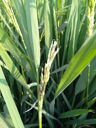

In [3]:
trn_path = path/'train_images'
files = get_image_files(trn_path)
im = PILImage.create(files[0])
print("image:", im.size)
print("tensor:", tensor(im).shape)
im.to_thumb(128)

Let's check image size over all files

In [4]:
%time x = [PILImage.create(o).size for o in files]
pd.Series(x).value_counts()

CPU times: user 29.5 s, sys: 641 ms, total: 30.2 s
Wall time: 30.2 s


(480, 640)    10403
(640, 480)        4
dtype: int64

from fastcore.parallel import *
def f(o): return PILImage.create(o).size
%time x = parallel(f, files, n_workers=8)
pd.Series(x).value_counts()

## Training

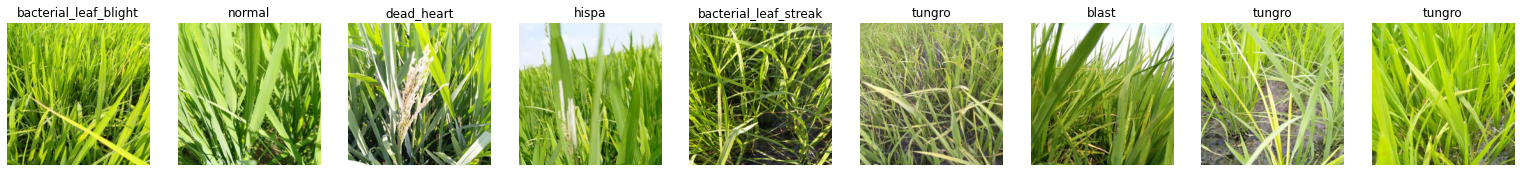

In [10]:
dls = ImageDataLoaders.from_folder(
    trn_path, valid_pct=0.2, item_tfms=Resize(480, method=ResizeMethod.Squish),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls.show_batch(ncols=9)

In [11]:
learn = vision_learner(dls, 'vit_small_patch16_224', metrics=error_rate, path='.').to_fp16()
learn.lr_find()

In [ ]:
learn.fine_tune(15, 5e-04)
learn.recorder.plot_loss()

epoch,train_loss,valid_loss,error_rate,time
0,0.038502,0.106838,0.025469,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.034094,0.105882,0.024988,00:40
1,0.039559,0.105995,0.024988,00:40


In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2))

Squish was better than padding

## Submitting

### Generating a CSV file to submit from test image prediction

In [7]:
def predict_test_in_csv(dls, learn, out_fname):
    files = get_image_files(path/'test_images').sorted()
    dl = dls.test_dl(files)
    _, _, idxs = learn.get_preds(dl=dl, with_decoded=True)
    ss = pd.read_csv(path/'sample_submission.csv')
    ss.label = pd.Series(idxs).map(dict(enumerate(dls.vocab)))
    ss.to_csv(out_fname, index=False)
    
predict_test_in_csv(dls, learn, 'subm.csv')
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,hispa
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


### Finally submitting competition

In [8]:
#api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)